In [ ]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
from icecream import ic
from tqdm import tqdm
from get_data import *
from dataloader import *

In [ ]:
# Import the data generated via matlab/simulink:

# see get_data.py for more info
data_tensor = get_data(path = "save_data_test3.csv", timesteps_from_data=0, skip_steps_start = 0, skip_steps_end = 0, drop_half_timesteps = False, normalise_s_w=True, rescale_p=False, num_inits=0)

# View an example of a simulation run
#visualise(data_tensor, num_inits=100)

In [ ]:
 #Define the LSTM model class

# Use the GPU if available
torch.set_default_dtype(torch.float64)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device="cpu"
print(device)

class LSTMmodel(nn.Module):
    """
    LSTM model class for derivative estimation.
    """

    def __init__(self, input_size, hidden_size, out_size, layers):
        """
        Initialize the LSTM model.

        Args:
        - input_size: Size of input
        - hidden_size: Size of hidden layer
        - out_size: Size of output
        - layers: Number of layers
        """
        super().__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.act = nn.ReLU()
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=layers, batch_first=True)

        # Define linear layer
        self.linear = nn.Linear(hidden_size, out_size)

    def forward(self, seq):
        """
        Forward pass through the LSTM model.

        Args:
        - seq: Input sequence

        Returns:
        - pred: Model prediction
        - hidden: Hidden state
        """
        lstm_out, hidden = self.lstm(seq)
        #lstm_out = self.act(lstm_out)
        pred = self.linear(lstm_out)

        return pred, hidden


class GRUmodel(nn.Module):
    """
    LSTM model class for derivative estimation.
    """

    def __init__(self, input_size, hidden_size, out_size, layers):
        """
        Initialize the LSTM model.

        Args:
        - input_size: Size of input
        - hidden_size: Size of hidden layer
        - out_size: Size of output
        - layers: Number of layers
        """
        super().__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size

        # Define LSTM layer
        self.lstm = nn.GRU(input_size, hidden_size, num_layers=layers, batch_first=True)

        # Define linear layer
        self.linear = nn.Linear(hidden_size, out_size)

    def forward(self, seq):
        """
        Forward pass through the LSTM model.

        Args:
        - seq: Input sequence

        Returns:
        - pred: Model prediction
        - hidden: Hidden state
        """
        lstm_out, hidden = self.lstm(seq)
        pred = self.linear(lstm_out)

        return pred, hidden


In [ ]:
def test(test_data, model, steps=600, ws=10, plot_opt=False, n = 5):

    #test_data = test_dataloader.get_all_data() 
    model.eval()
    loss_fn = nn.MSELoss()
    test_loss = 0
    test_loss_deriv = 0
    total_loss = 0
    #np.random.seed(123)
    ids = np.random.choice(test_data.size(dim=0), min([n, test_data.size(dim=0)]), replace=False)
    ids = np.unique(ids)

    for i, x in enumerate(test_data):
        x=x.to(device)
        if i not in ids:
            continue

        with torch.inference_mode():

            pred = torch.zeros((steps, 3), device=device)
            pred_next_step = torch.zeros((steps, 3), device=device)

            if ws > 1:
                pred[0:ws, :] = x[0:ws, :]
                pred[:, 0] = x[:, 0]
                pred_next_step[0:ws, :] = x[0:ws, :]
                pred_next_step[:, 0] = x[:, 0]
            else:
                pred[0, :] = x[0, :]
                pred[:, 0] = x[:, 0]
                pred_next_step[0, :] = x[0, :]
                pred_next_step[:, 0] = x[:, 0]

            for i in range(len(x) - ws):

                out, _ = model(pred[i:i+ws, :])
                pred[i+ws, 1:] = pred[i+ws-1, 1:] + out[-1, :]
                pred_next_step[i+ws, 1:] = x[i+ws-1, 1:] + out[-1, :]
            
            test_loss += loss_fn(pred[:, 1], x[:, 1]).detach().cpu().numpy()
            test_loss_deriv += loss_fn(pred[:, 2], x[:, 2]).detach().cpu().numpy()

            total_loss += loss_fn(pred[:, 1:], x[:, 1:]).detach().cpu().numpy()

            if plot_opt:
                figure , axs = plt.subplots(1,3,figsize=(16,9))
            
                axs[0].plot(pred.detach().cpu().numpy()[:, 1], color="red", label="pred")
                axs[0].plot(pred_next_step.detach().cpu().numpy()[:, 1], color="green", label="next step from data")
                axs[0].plot(x.detach().cpu().numpy()[:, 1], color="blue", label="true", linestyle="dashed")
                axs[0].set_title("position")
                axs[0].grid()
                axs[0].legend()

                axs[1].plot(pred.detach().cpu().numpy()[:, 2], color="red", label="pred")
                axs[1].plot(pred_next_step.detach().cpu().numpy()[:, 2], color="green", label="next step from data")
                axs[1].plot(x.detach().cpu().numpy()[:, 2], color="blue", label="true", linestyle="dashed")
                axs[1].set_title("speed")
                axs[1].grid()
                axs[1].legend()

                axs[2].plot(x.detach().cpu().numpy()[:,0], label="pressure")
                axs[2].set_title("pressure")
                axs[2].grid()
                axs[2].legend()

                plt.grid(True)
                plt.legend()
                plt.show()
            
    return np.mean(test_loss), np.mean(test_loss_deriv), np.mean(total_loss)


In [ ]:
#works:
def train1(input_data, model, weight_decay, future_decay, learning_rate=0.001, ws=0, future=1):
    """
    Train the LSTM model using input data.

    Args:
    - input_data: Input data for training
    - model: LSTM model to be trained
    - ws: Window size
    - odestep: Option for using ODE steps
    - use_autograd: Option for using autograd

    Returns:
    - Mean loss over all batches
    """
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

    model.train()
    total_loss = []

    for k, (inp, label) in enumerate(input_data):  # inp = (u, x) label = x
        #print(k, f"timesteps {k} : {k+4} mit label bis {k+6}")
        inp=inp.to(device)
        label=label.to(device)

        # Predict one timestep :
        output, _ = model(inp)
        out = inp[:, :, 1:] + output

        # print("inp", inp, inp.size())
        # print("label", label, label.size())
        # print("out", out, out.size())
        
        #1. extra step-------------------------
        if future>1:
            new_combined_inp = torch.cat((label[:, 0, 0:1], out[:,-1,:]), dim=1)
            new_combined_inp = new_combined_inp.view(inp.size(dim=0),1,3)

            #print("new_combined_inp", new_combined_inp, new_combined_inp.size())

            inp2 = torch.cat((inp[: , 1:ws,:], new_combined_inp), dim =1)        
            #print("inp2" , inp2, inp2.size())

            output2, _ = model(inp2)
            out2 = inp2[:, :, 1:] + output2

            #print("out2", out2, out2.size())

        #2. extra step-------------------------
        if future > 2:
            #new_combined_inp2 = torch.cat((label[:, 1, 0:1], out2[:,-1,:].clone()), dim=1)
            new_combined_inp2 = torch.cat((label[:, 1, 0:1], out2[:,-1,:]), dim=1)
            new_combined_inp2 = new_combined_inp2.view(inp2.size(dim=0),1,3)

            inp3 = torch.cat((inp2[: , 1:ws,:], new_combined_inp2), dim =1)        

            output3, _ = model(inp3)
            out3 = inp3[:, :, 1:] + output3
        
        #3. extra step-------------------------
        if future > 3:
            new_combined_inp3 = torch.cat((label[:, 1, 0:1], out3[:,-1,:].clone()), dim=1)
            new_combined_inp3 = new_combined_inp3.view(inp2.size(dim=0),1,3)

            inp4 = torch.cat((inp3[: , 1:ws,:], new_combined_inp3), dim =1)        

            output4, _ = model(inp4)
            out4 = inp4[:, :, 1:] + output4

        # reset the gradient
        
        optimizer.zero_grad(set_to_none=True)
        # calculate the error
        if future<2:
            loss = loss_fn(out[:,-1,:], label[:, 1:])
        else:   
            loss = loss_fn(out[:,-1,:], label[:, 0, 1:])

        #backpropagation
        if future>1:
            loss2 = future_decay * loss_fn(out2[:,-1,:], label[:, 1, 1:])
            loss += loss2
        if future>2:
            loss3 = future_decay * loss_fn(out3[:,-1,:], label[:, 2, 1:])
            loss += loss3
        if future>3:
            loss4 = future_decay * loss_fn(out4[:,-1,:], label[:, 3, 1:])
            loss += loss4
            print(loss4)

        
        loss.backward(retain_graph=True)
        optimizer.step()


        total_loss.append(loss.detach().cpu().numpy())

   # return the average error of the next step prediction
    return np.mean(total_loss)



In [ ]:

def train(input_data, model, weight_decay, future_decay, learning_rate=0.001, ws=0, future=1, timesteps=0, batch_size=0):

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

    model.train()
    total_loss = []

    for k, (inp, label) in enumerate(input_data):  

        if ((k+1)%(timesteps/batch_size))*(batch_size + ws + future) > timesteps:
            continue

        
        inp=inp.to(device)
        label=label.to(device)

        # Predict one timestep :
        output, _ = model(inp)
        out = inp[:, :, 1:] + output
        
        inputs = []
        outputs = [out]
        outputs_net = [output]
        loss_future = []
        new_combined_inp=[]
        
        for t in range(future-1): 
           
            new_combined_inp.append(torch.cat((label[:, t, 0:1], outputs[t][:,-1,:]), dim=1).view(inp.size(dim=0),1,3))
            
            if t>0:
                inputs.append(torch.cat((inputs[t-1][: , 1:ws,:], new_combined_inp[t]), dim =1))
            else:
                inputs.append(torch.cat((inp[: , 1:ws,:], new_combined_inp[t]), dim =1))

            outputs_net.append(model(inputs[t])[0])
            outputs.append(inputs[t][:, :, 1:] + outputs_net[t])

            loss_future.append(loss_fn(outputs[t][:,-1,:], label[:, t+1, 1:]))


        # reset the gradient
        
        optimizer.zero_grad(set_to_none=True)
        # calculate the error
        if future<2:
            loss = loss_fn(out[:,-1,:], label[:, 1:])
        else:   
            loss = loss_fn(out[:,-1,:], label[:, 0, 1:])

        #backpropagation
        if future>1:
            for loss_f in loss_future:
             loss += future_decay * loss_f

            loss.backward(retain_graph=True)
            optimizer.step()
        loss_future[0].backward()

        total_loss.append(loss.detach().cpu().numpy())

   # return the average error of the next step prediction
    return np.mean(total_loss)



In [ ]:

# set some parameters for learning 
                    #window_size, h_size,  l_num,  epochs, learning_rate,  part_of_data,   weight_decay,   percentage_of_data    future_decay      batch_size
parameter_sets  =    [4,             5 ,      1,       10,       5*0.0001,           100,           1e-5,               0.8,               1 ,           64]
           # {'lr': 0.0006226762071294569, 'ws': 9, 'bs': 51, 'hs': 13, 'ls': 2}         
window_size, h_size, l_num, epochs, learning_rate, part_of_data, weight_decay,  percentage_of_data, future_decay, batch_size = parameter_sets

future =4 

# Initialize the LSTM model
#model = LSTMmodel(input_size=3, hidden_size=h_size, out_size=2, layers=l_num).to(device)
model = LSTMmodel(input_size=3, hidden_size=h_size, out_size=2, layers=l_num).to(device)
# Generate input data (the data is normalized and some timesteps are cut off)
input_data = get_data(path = "save_data_test3.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = False,
                        normalise_s_w=True,
                        rescale_p=False,
                        num_inits=part_of_data)

cut_off_timesteps = 800
print(input_data.size())
#Split data into train and test sets

num_of_inits_train = int(len(input_data)*percentage_of_data)
train_inits = np.random.randint(0,len(input_data), num_of_inits_train)
train_inits = np.unique(train_inits)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])

# make sure we really get the specified percentage of training data..
if percentage_of_data < 0.99: 
        while len(train_inits) < num_of_inits_train:
            i = np.random.randint(0,len(test_inits),1)[0]
            train_inits = np.append(train_inits,test_inits[i])
            test_inits = np.delete(test_inits, i)

train_data = input_data[train_inits,:input_data.size(dim=1)-cut_off_timesteps,:]
test_data = input_data[test_inits,:,:]
print(train_data.size())

data_set  = CustomDataset(train_data, window_size=window_size, future=future)
train_dataloader = DataLoader(data_set, batch_size=batch_size, pin_memory=True, drop_last=True)

losses = []
average_traj_err_train = []
average_traj_err_test = []

for e in tqdm(range(epochs)):
    
    loss_epoch = train1(train_dataloader, model, weight_decay, future_decay, learning_rate=learning_rate, ws=window_size, future=future)#, timesteps=train_data.size(dim=1), batch_size=batch_size)
    losses.append(loss_epoch)

    # Every few epochs get the error MSE of the true data
    # compared to the network prediction starting from some initial conditions
    if (e+1)%2 == 0:
        _,_, err_train = test(train_data, model, steps=train_data.size(dim=1), ws=window_size, plot_opt=False, n = 20)
        _,_, err_test = test(test_data, model, steps=test_data.size(dim=1), ws=window_size, plot_opt=False, n = 20)
        average_traj_err_train.append(err_train)
        average_traj_err_test.append(err_test)
        print(f"Epoch: {epochs}, the average next step error was : loss_epoch")
        print(f"Average error over full trajectories: training data : {err_train}")
        print(f"Average error over full trajectories: testing data : {err_test}")

_,_, err_train = test(train_data, model, steps=train_data.size(dim=1), ws=window_size, plot_opt=False, n = 100)
_,_, err_test = test(test_data, model, steps=test_data.size(dim=1), ws=window_size, plot_opt=False, n = 100)
print(f"TRAINING FINISHED: Average error over full trajectories: training data : {err_train}")
print(f"TRAINING FINISHED: Average error over full trajectories: testing data : {err_test}")
        

In [ ]:
# Save the model
path = f"Ventil_trained_NNs\my_example_model.pth"
torch.save(model.state_dict(), path)

# Load the model and test it on the test data

path = "Ventil_trained_NNs\my_example_model.pth"
model = LSTMmodel(input_size=3, hidden_size=h_size, out_size=2, layers=l_num).to(device)
model.load_state_dict(torch.load(path, map_location=torch.device(device)))

train_data = input_data[train_inits,:,:]

test_loss, test_loss_deriv, total_loss = test(test_data, model, steps=input_data.size(dim=1), ws=window_size, plot_opt=True , n = 3)


ic(test_loss, test_loss_deriv, total_loss)

In [ ]:
parameter_list = ["window_size", "batch_size", "future",  "h_size",  "l_num",  "epochs", "learning_rate", "weight_decay",  "part_of_data",  "percentage_of_data" ]

param_dic = {x : 0 for x in parameter_list}


param_dic


torch.Size([500, 1100, 3])


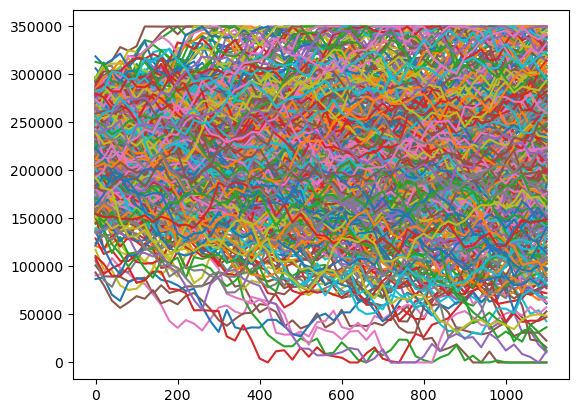

In [12]:

# set some parameters for learning 
                    #window_size, h_size,  l_num,  epochs, learning_rate,  part_of_data,   weight_decay,   percentage_of_data    future_decay      batch_size
parameter_sets  =    [4,             5 ,      1,       10,       5*0.0001,           0,           1e-5,               0.8,               1 ,           64]
           # {'lr': 0.0006226762071294569, 'ws': 9, 'bs': 51, 'hs': 13, 'ls': 2}         
window_size, h_size, l_num, epochs, learning_rate, part_of_data, weight_decay,  percentage_of_data, future_decay, batch_size = parameter_sets

future =4 

# Initialize the LSTM model
#model = LSTMmodel(input_size=3, hidden_size=h_size, out_size=2, layers=l_num).to(device)
model = LSTMmodel(input_size=3, hidden_size=h_size, out_size=2, layers=l_num).to(device)
# Generate input data (the data is normalized and some timesteps are cut off)
input_data = get_data(path = "save_data_test3.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = False,
                        normalise_s_w=False,
                        rescale_p=False,
                        num_inits=part_of_data)

print(input_data.size())

for x in input_data:
    plt.plot(x[:,0])